In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [2]:
data_path = "data/creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
normal = df[df.Class == 0]
anomaly = df[df.Class == 1]

print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (284315, 30)
Anomaly: (492, 30)


In [4]:
# Séparation des données en train, validation et test
seed = 2025
X = df.drop(columns=['Class'])
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.4, 
    random_state=seed, 
    stratify=y
)

X_test, X_validate, y_test, y_validate = train_test_split(
    X_test, y_test,
    test_size=0.5, 
    random_state=seed, 
    stratify=y_test
)

print("X_train shape, y_train shape :", X_train.shape, y_train.shape)
print("X_validate shape, y_validate shape :", X_validate.shape, y_validate.shape)
print("X_test shape, y_test shape :", X_test.shape, y_test.shape)

print("Class distribution in train set :", y_train.value_counts(normalize=True))
print("Class distribution in validate set :", y_validate.value_counts(normalize=True))
print("Class distribution in test set :", y_test.value_counts(normalize=True))

X_train shape, y_train shape : (170884, 29) (170884,)
X_validate shape, y_validate shape : (56962, 29) (56962,)
X_test shape, y_test shape : (56961, 29) (56961,)
Class distribution in train set : Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64
Class distribution in validate set : Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64
Class distribution in test set : Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


# Entraînement et Evaluation avec MLFlow

In [5]:
def train(sk_model, X_train, y_train):
    sk_model = sk_model.fit(X_train, y_train)
    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [7]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)

    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)

    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)

    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")

    RocCurveDisplay.from_estimator(
        sk_model,
        x_test,
        y_test
    )
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()

    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

Train Accuracy: 100.000%
Auc Score: 90.402%
Eval Accuracy: 99.963%


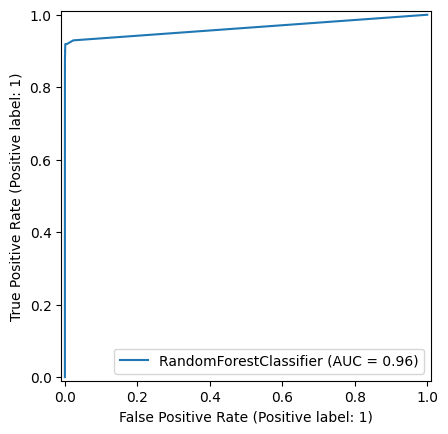

Model run:  77bceb1ab8ee4c86bfcf3c8d10a2787e


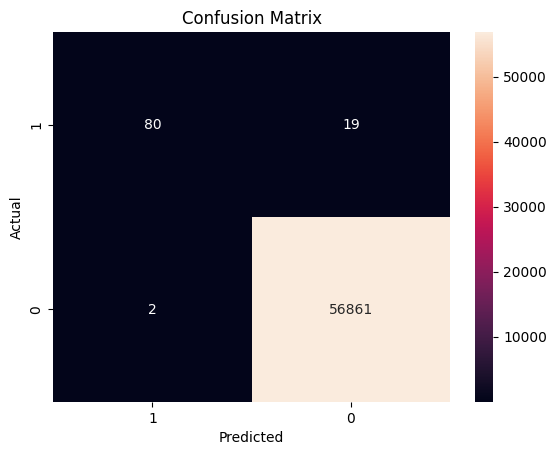

In [10]:
sk_model = RandomForestClassifier(
    random_state=seed,
    class_weight='balanced',
    n_jobs=-1
)

mlflow.set_experiment("scikit_learn_experiment")

# Exemple : une ligne du jeu d'entraînement
input_example = X_train.iloc[:1] #optionnel

with mlflow.start_run():
    train(sk_model, X_train, y_train)
    signature = infer_signature(X_train, sk_model.predict(X_train)) #optionnel
    evaluate(sk_model, X_validate, y_validate)
    mlflow.sklearn.log_model(
        sk_model, 
        "rf_default_model", 
        input_example=input_example, # optionnel
        signature=signature # optionnel
    )
    print("Model run: ", mlflow.active_run().info.run_id)
mlflow.end_run()

In [11]:
# Chargement d'un modèle enregistré (charger un modèle à partir d’une exécution MLFlow spécifique.)
model_uri = 'runs:/1d8d2cd505cf46649b0fa742dfaf31f8/rf_default_model'
loaded_model = mlflow.sklearn.load_model(model_uri)
loaded_model

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=2025)

In [12]:
type(loaded_model)

sklearn.ensemble._forest.RandomForestClassifier

In [13]:
loaded_model.score(X_validate, y_validate)

0.9996313331694814

Le code ci-dessous permet de valider le fonctionnement de l'inférence du modèle sur les données d'entrée d'exemple et les dépendances du modèle enregistrées, avant de le déployer sur un point de terminaison.

In [ ]:
model_uri = 'runs:/1d8d2cd505cf46649b0fa742dfaf31f8/rf_default_model'

# Replace INPUT_EXAMPLE with your own input example to the model
# A valid input example is a data instance suitable for pyfunc prediction
input_example = X_train.iloc[:1]
input_data = input_example

# Verify the model with the provided input data using the logged dependencies.
# For more details, refer to:
# https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
mlflow.models.predict(
    model_uri=model_uri,
    input_data=input_data,
    env_manager="uv", # Installer préalablement uv avec pip install uv dans le terminal
)

2025/05/04 19:21:18 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2025/05/04 19:21:18 INFO mlflow.utils.virtualenv: Creating a new environment in /tmp/tmp_f3_eddq/envs/virtualenv_envs/mlflow-5162b661418fa5070e40b6232eee6357770f81d6 with python version 3.12.3 using uv


Using CPython 3.12.3 interpreter at: /usr/bin/python3.12
Creating virtual environment at: /tmp/tmp_f3_eddq/envs/virtualenv_envs/mlflow-5162b661418fa5070e40b6232eee6357770f81d6
Activate with: source /tmp/tmp_f3_eddq/envs/virtualenv_envs/mlflow-5162b661418fa5070e40b6232eee6357770f81d6/bin/activate
2025/05/04 19:21:19 INFO mlflow.utils.virtualenv: Installing dependencies
Using Python 3.12.3 environment at: /tmp/tmp_f3_eddq/envs/virtualenv_envs/mlflow-5162b661418fa5070e40b6232eee6357770f81d6
Resolved 3 packages in 434ms
Prepared 3 packages in 663ms
Installed 3 packages in 43ms
 + pip==24.0
 + setuptools==80.2.0
 + wheel==0.45.1
Using Python 3.12.3 environment at: /tmp/tmp_f3_eddq/envs/virtualenv_envs/mlflow-5162b661418fa5070e40b6232eee6357770f81d6
Resolved 75 packages in 2.48s
Prepared 75 packages in 14.92s
Installed 75 packages in 252ms
 + alembic==1.15.2
 + annotated-types==0.7.0
 + anyio==4.9.0
 + blinker==1.9.0
 + cachetools==5.5.2
 + certifi==2025.4.26
 + charset-normalizer==3.4.2
 + 

{"predictions": [0]}

Le code ci-dessous est un exemple de comment utiliser un modèle MLflow pour réaliser des prédictions :

In [17]:
logged_model = 'runs:/1d8d2cd505cf46649b0fa742dfaf31f8/rf_default_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
predictions = loaded_model.predict(X_validate)
predictions

array([0, 0, 0, ..., 0, 0, 0], shape=(56962,))

# Intégration de MLflow dans la validation avec de modèle avec Réglage d'hyperparamètres

In [19]:

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, RocCurveDisplay

# Définir l'espace de recherche
param_distributions = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

# Configuration CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modèle de base
base_model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Recherche aléatoire
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    scoring='recall',  # pour privilégier la détection de la classe 1
    n_iter=7,
    cv=cv_strategy,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Lancer l'expérience MLflow
mlflow.set_experiment("RandomForest_Tuning")

with mlflow.start_run():
    # Fit la recherche
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    
    # Log des hyperparamètres
    mlflow.log_params(search.best_params_)

    # Évaluation sur la validation
    y_pred = best_model.predict(X_validate)
    y_proba = best_model.predict_proba(X_validate)[:, 1]

    acc = accuracy_score(y_validate, y_pred)
    recall = recall_score(y_validate, y_pred)
    auc = roc_auc_score(y_validate, y_proba)

    mlflow.log_metric("val_accuracy", acc)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_auc", auc)

    # Signature et input example
    input_example = X_train.iloc[:1]
    signature = infer_signature(X_train, best_model.predict(X_train))

    mlflow.sklearn.log_model(
        best_model,
        "best_rf_model",
        input_example=input_example,
        signature=signature
    )

    # Courbe ROC
    RocCurveDisplay.from_estimator(best_model, X_validate, y_validate)
    plt.title("ROC Curve")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.clf()

    # Matrice de confusion
    conf_matrix = confusion_matrix(y_validate, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("conf_matrix.png")
    mlflow.log_artifact("conf_matrix.png")
    plt.clf()

    print("MLflow run ID:", mlflow.active_run().info.run_id)

mlflow.end_run()

2025/05/04 19:35:40 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest_Tuning' does not exist. Creating a new experiment.


Fitting 5 folds for each of 7 candidates, totalling 35 fits
MLflow run ID: f10b810068644dcabf80db59a15d97b8


<Figure size 640x480 with 0 Axes>

In [20]:
from sklearn.model_selection import ParameterSampler
import os

# Paramètres à explorer
param_distributions = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

# Génère 20 combinaisons aléatoires
param_list = list(ParameterSampler(param_distributions, n_iter=5, random_state=42))

# Dossier pour les artefacts
os.makedirs("artifacts", exist_ok=True)

# MLflow
mlflow.set_experiment("RF_Tuning_Manual")

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"run_{i+1}"):
        # Définir le modèle
        model = RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_jobs=-1,
            **params
        )
        
        # Entraînement
        model.fit(X_train, y_train)

        # Prédictions
        y_pred = model.predict(X_validate)
        y_proba = model.predict_proba(X_validate)[:, 1]

        # Métriques
        acc = accuracy_score(y_validate, y_pred)
        recall = recall_score(y_validate, y_pred)
        auc = roc_auc_score(y_validate, y_proba)

        # Log des hyperparams et métriques
        mlflow.log_params(params)
        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_recall", recall)
        mlflow.log_metric("val_auc", auc)

        # Input example et signature
        input_example = X_train.iloc[:1]
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, "model", input_example=input_example, signature=signature)

        # ROC
        RocCurveDisplay.from_estimator(model, X_validate, y_validate)
        roc_path = f"artifacts/roc_curve_{i+1}.png"
        plt.title("ROC Curve")
        plt.savefig(roc_path)
        mlflow.log_artifact(roc_path)
        plt.clf()

        # Confusion matrix
        conf_matrix = confusion_matrix(y_validate, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='g')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        conf_path = f"artifacts/conf_matrix_{i+1}.png"
        plt.savefig(conf_path)
        mlflow.log_artifact(conf_path)
        plt.clf()

        print(f"Logged run {i+1}/{len(param_list)} - AUC: {auc:.3f} - Recall: {recall:.3f}")

2025/05/04 20:46:32 INFO mlflow.tracking.fluent: Experiment with name 'RF_Tuning_Manual' does not exist. Creating a new experiment.


Logged run 1/5 - AUC: 0.981 - Recall: 0.869
Logged run 2/5 - AUC: 0.982 - Recall: 0.859
Logged run 3/5 - AUC: 0.980 - Recall: 0.879
Logged run 4/5 - AUC: 0.977 - Recall: 0.899
Logged run 5/5 - AUC: 0.972 - Recall: 0.838


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>